In [1]:
!apt update
!apt install enchant --fix-missing
!apt install -qq enchant
!pip install pyenchant
!pip install kneed

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Building dependency tree       
Reading state infor

In [2]:
from google.colab import drive
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from sklearn.cluster import KMeans
# from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import Word2Vec
from tqdm import tqdm
import enchant
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture as GMM
from sklearn.preprocessing import StandardScaler


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
# Avoid warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
## mount the working directory
drive.mount("text_clustering")

Drive already mounted at text_clustering; to attempt to forcibly remount, call drive.mount("text_clustering", force_remount=True).


In [5]:
## read the dataset
df = pd.read_excel("/content/text_clustering/MyDrive/text_clustering/data.xlsx")

In [6]:
########## shuffle the data and get the percentage of data.
df_sample = df.sample(frac=0.99,random_state=0)

####### filter the key and content columns
df_1 = df_sample[["content","key"]]


In [7]:
## pre-define function for cleaning the tweets
d = enchant.Dict("en_US")
lemmetizer = WordNetLemmatizer()
def clean_tweet(text):
    clean_text = text.lower()
    clean_text = re.sub("'", "", clean_text) # to avoid removing contractions in english
    clean_text = re.sub("@[A-Za-z0-9_]+","", clean_text)
    clean_text = re.sub("#[A-Za-z0-9_]+","", clean_text)
    clean_text = re.sub(r'http\S+', '', clean_text)
    clean_text = re.sub('[()!?]', ' ', clean_text)
    clean_text = re.sub('\[.*?\]',' ', clean_text)
    clean_text = re.sub("[^a-zA-Z]"," ", clean_text)
    clean_text = clean_text.strip().split()
    clean_text = [i for i in clean_text if d.check(i)==True and len(i)>2 ]
    # clean_text_1 = [i for i in clean_text if len(i)>2]
    clean_text_2 = [lemmetizer.lemmatize(word) for word in clean_text if word not in set(stopwords.words("english"))]
    if len(clean_text_2)>2:
      clean_text_3 =  " ".join(clean_text_2)
    else:
       clean_text_3 = np.nan

    return clean_text_3


In [8]:

##### apply the defined function to the "content" column
df_1["clean_content"] = df_1["content"].apply(lambda x: clean_tweet(x))

In [9]:
df_1.head()

,content,key,clean_content
8382,"@Dog3Chi3f sorry it was an accident,don't call...",accident,sorry accident call police
8037,@voxdotcom @emilyvdw My dog has been neutered....,child abuse,dog neutered neighbor bull castrated reaching ...
21338,"@biggameJames_36 Flash floods, and some of the...",floods,flash flood photo coming wild
18139,"@DonaldJTrumpJr So, theft of US govt documents...",theft,theft govt document wrong transgender large se...
10776,@AncapAurelius @Grn_eggsn_Sam @AlexCTaliadoros...,theft,inflation new money injected economy inflation...


In [10]:
## drop duplicates and null raws
df_2 = df_1.drop_duplicates(subset=["clean_content"])
df_3= df_2[df_2["clean_content"].notna()]

In [11]:
df.shape, df_1.shape, df_2.shape, df_3.shape

((22399, 4), (22175, 3), (21720, 3), (21719, 3))

In [12]:
df_3["clean_content_split"] = df_3["clean_content"].apply(lambda x: x.split(" "))

In [13]:
corpus = df_3["clean_content_split"].tolist()

In [14]:
######### Create Word2Vec model with Average Word2vec
def avg_wor2vec(corpus,vector_size):
    model= Word2Vec(corpus, size=vector_size)
    X= []
    for i in tqdm(range(len(corpus))):
      avg = np.mean([model.wv[word] if word in model.wv.index2word else np.zeros(100) for word in corpus[i]],axis = 0)
      X.append(avg)
    return X


In [15]:
X = avg_wor2vec(corpus,100)

100%|██████████| 21719/21719 [00:09<00:00, 2408.37it/s]


In [16]:
# scaling and find the cumulative explained variance of PCA
def varicance_captured_pca(vectoried_data):
  scaler = StandardScaler()
  vectoried_data_scaled = scaler.fit_transform(vectoried_data)
  pca = PCA().fit(vectoried_data_scaled)
  plt.plot(np.cumsum(pca.explained_variance_ratio_))
  plt.xlabel('number of components')
  plt.ylabel('cumulative explained variance')
  # plt.savefig("PCA_reduce_100_dimension_after_scaling.png")
  plt.show()

  return plt, vectoried_data_scaled

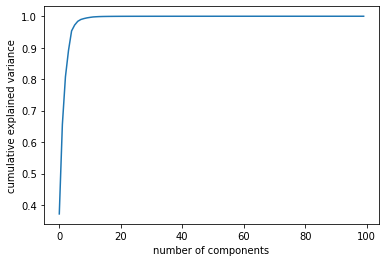

In [17]:
fig, vectoried_data_scaled = varicance_captured_pca(X)
# 5 components have been selected because it can capture more than 85% of variance of data

In [18]:
pca_selected = PCA(5)
pca_fit = pca_selected.fit_transform(vectoried_data_scaled)

**Kmeans clustering**

In [19]:
############# fit Kmeans clustering for the pca_fit

In [20]:
def KMeans_elbow(data,fig_name):
  wcss = []
  for i in tqdm(range(1,50)):
      model_kmeans = KMeans(n_clusters=i,init="k-means++",random_state=0,)
      model_kmeans.fit(data)
      wcss.append(model_kmeans.inertia_)
    
  plt.plot(range(1,50),wcss, 'bx-' )
  plt.Figure(figsize=(20,20))
  plt.title(fig_name)
  plt.xlabel("Number of clusters")
  plt.ylabel("WCSS")
  # plt.savefig(fig_name)
  plt.show()
  

100%|██████████| 49/49 [03:11<00:00,  3.92s/it]


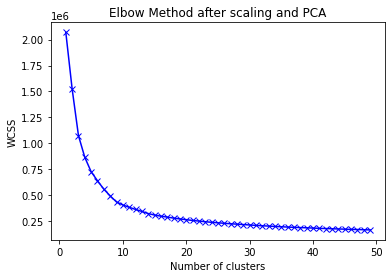

In [21]:
kmeans_fig = KMeans_elbow(pca_fit,"Elbow Method after scaling and PCA")


In [22]:
### selected number of clusters from Elbow method (10,15,20)

In [45]:
def get_sillhette_score(range_of_clusters,data):
  for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        data[:, 0], data[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
    # plt.savefig("Silhouette score _ {}".format(n_clusters))
  plt.show()

For n_clusters = 5 The average silhouette_score is : 0.2773613616768797
For n_clusters = 9 The average silhouette_score is : 0.2797271626677567
For n_clusters = 10 The average silhouette_score is : 0.2785034823236359
For n_clusters = 12 The average silhouette_score is : 0.2500742847474379
For n_clusters = 15 The average silhouette_score is : 0.24516748070912778
For n_clusters = 20 The average silhouette_score is : 0.22424085403196364


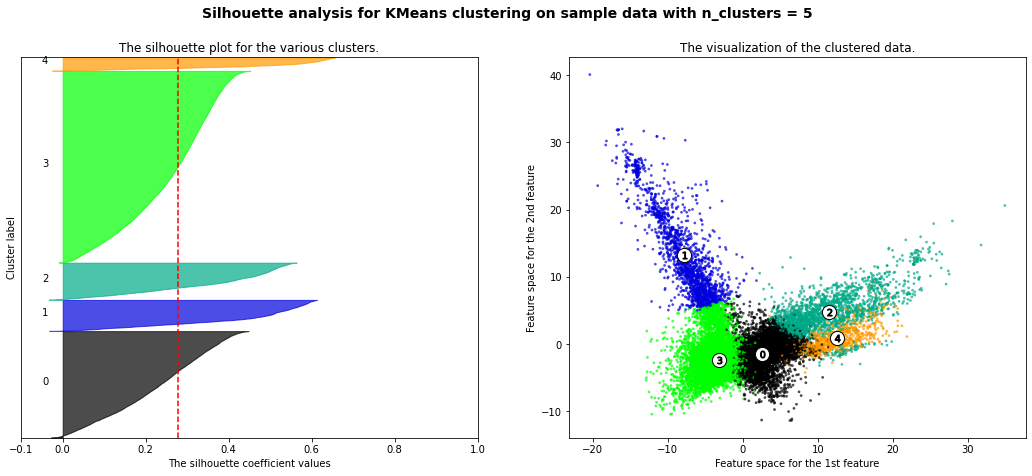

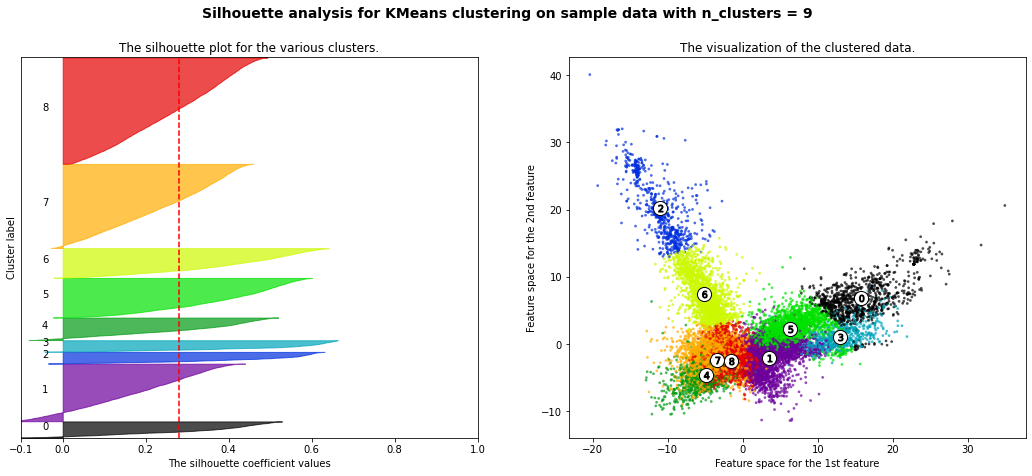

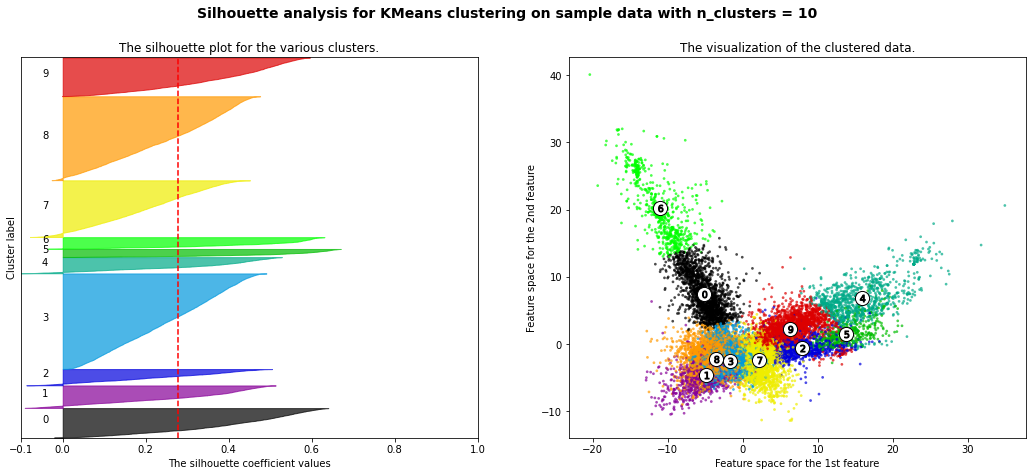

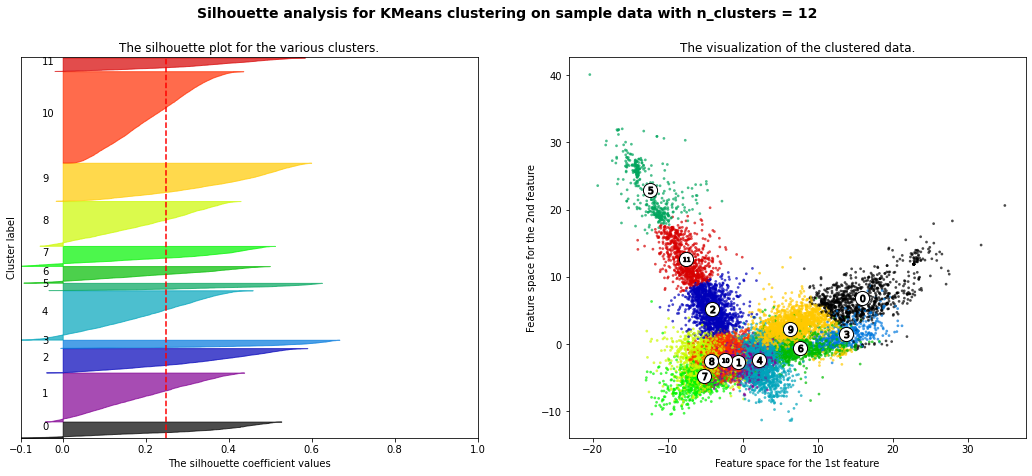

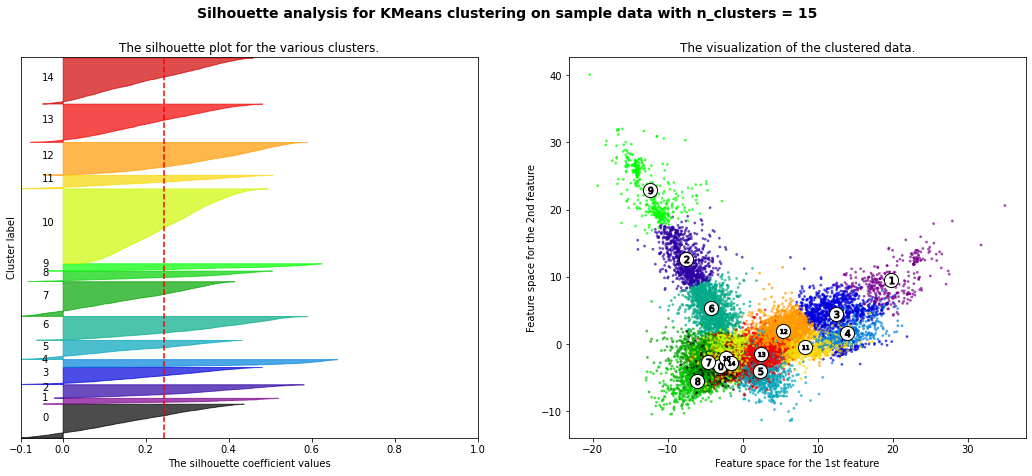

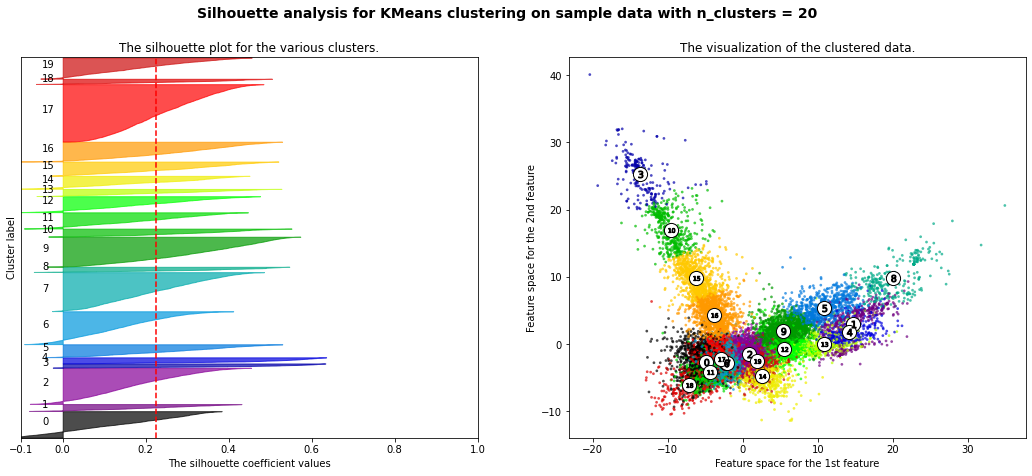

In [47]:
# Validate the number of culsters using silhouette score
range_n_clusters = [5,9,10,12,15,20]
fig_sillhoette_score = get_sillhette_score(range_n_clusters,pca_fit)


In [ ]:
# The highest silhouette score is  0.2797271626677567 for n which is less than 0.5 n_clusters = 9 
# however this is not a good score to fit a model. it should be more than 0.5 (or at least 0.5)
# Thus, KMeans clustering is not suit for the dataset

DBSCAN

<Figure size 1440x720 with 0 Axes>

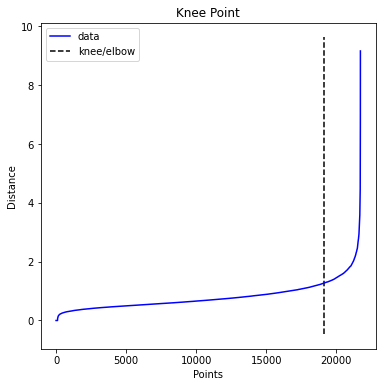

1.2677524510496825


In [25]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(pca_fit)

distances, indices = nbrs.kneighbors(pca_fit)
distances = np.sort(distances[:,1], axis=0)

############## Plotting K-distance Graph with Knee

# a=distances[:,1]
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(20,10))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
# plt.savefig("K-distance graph with Knee")
plt.show()
print(distances[knee.knee])

In [26]:
# Since Knee point is 1, the epsilon starts from 1

In [28]:
# find the best parameter for DBSCAN
list_eps = list(np.arange(1, 3, 0.5))
list_min_sample = [5,10,15,20,30,50,80,90]

silhouette =[]
number_cluster =[]
diff_clust =[]
for e in tqdm(list_eps): 
    for s in list_min_sample:
        print(e,s)
        dbscan = DBSCAN(eps =e,min_samples=s)
        dbscan.fit(pca_fit)
        
        cluster = dbscan.labels_
        cluster_no = len(set(cluster))
        clusters = set(cluster)
        print(cluster_no)
        silhou_score_= silhouette_score(pca_fit, cluster)
        silhouette.append(silhou_score_)
        number_cluster.append(cluster_no)
        diff_clust.append(clusters)

  0%|          | 0/4 [00:00<?, ?it/s]

1.0 5
117
1.0 10
30
1.0 15
14
1.0 20
10
1.0 30
3
1.0 50
2
1.0 80
2
1.0 90
2


 25%|██▌       | 1/4 [00:43<02:11, 43.91s/it]

1.5 5
37
1.5 10
23
1.5 15
15
1.5 20
12
1.5 30
6
1.5 50
4
1.5 80
3
1.5 90
3


 50%|█████     | 2/4 [01:31<01:32, 46.29s/it]

2.0 5
13
2.0 10
7
2.0 15
7
2.0 20
7
2.0 30
7
2.0 50
6
2.0 80
2
2.0 90
2


 75%|███████▌  | 3/4 [02:24<00:49, 49.35s/it]

2.5 5
6
2.5 10
3
2.5 15
3
2.5 20
4
2.5 30
5
2.5 50
6
2.5 80
3
2.5 90
2


100%|██████████| 4/4 [03:25<00:00, 51.28s/it]


In [29]:
list_eps_min_sample = []
for e in list_eps: 
    for s in list_min_sample:
        list_eps_min_sample.append([e,s])
      
silhouette.index(max(silhouette))
mapped =list(zip(list_eps_min_sample,number_cluster,silhouette))
df_silhoutette = pd.DataFrame(mapped,columns=["list_eps_min_sample","number_cluster","silhouette"])

In [32]:
df_silhoutette.sort_values("silhouette",ascending=False)
# The best score obtained for [2.5, 90] -[list_eps,list_min_sample]

,list_eps_min_sample,number_cluster,silhouette
31,"[2.5, 90]",2,0.427533
30,"[2.5, 80]",3,0.418051
26,"[2.5, 15]",3,0.408155
27,"[2.5, 20]",4,0.403571
25,"[2.5, 10]",3,0.396487
28,"[2.5, 30]",5,0.378722
22,"[2.0, 80]",2,0.335867
23,"[2.0, 90]",2,0.323442
21,"[2.0, 50]",6,0.319188
17,"[2.0, 10]",7,0.302820


In [34]:
# fit the DBSCAN model with the above parameters
dbscan = DBSCAN(eps =2.0,min_samples=90)
dbscan.fit(pca_fit)
# assign labels
cluster_dbscan = dbscan.labels_

df_final_dbscan = df_3[['content', 'key', 'clean_content']]
# add assigned label to dataframe
df_final_dbscan["clusters_eps_2_min_sample_90"]= cluster_dbscan.tolist()
df_final_dbscan.to_excel("/content/text_clustering/MyDrive/text_clustering/df_with_DBSCAN.xlsx")

# No clusters as expected
# Thus, we can use DBSCAN method to remove outliers and fit KMeans again


In [36]:
############## Removing outliers 

df_rmd_outlier= df_final_dbscan.loc[df_final_dbscan["clusters_eps_2_min_sample_90"]!=-1] 
df_rmd_outlier = df_rmd_outlier[['content', 'key', 'clean_content']]

In [37]:
df_rmd_outlier["clean_content_split"] = df_rmd_outlier["clean_content"].apply(lambda x: x.split(" "))
corpus_rmd_outliers = df_rmd_outlier["clean_content_split"].tolist()

In [38]:
X_rmd_outliers = avg_wor2vec(corpus_rmd_outliers,100)

100%|██████████| 15502/15502 [00:07<00:00, 1992.59it/s]


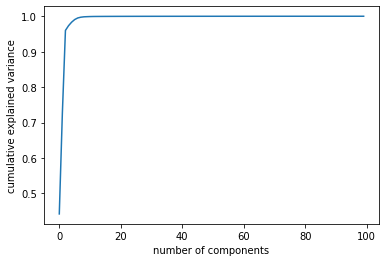

In [39]:
fig_rmd_outlier, vectoried_data_scaled_rmd_outliers = varicance_captured_pca(X_rmd_outliers)

In [43]:
# for pca= 2, 723% and pca=3, 96% of variance captured, pca=3 has selected
pca_selected_rmd_outliers = PCA(3)
pca_fit_rmd_outliers = pca_selected_rmd_outliers.fit_transform(vectoried_data_scaled_rmd_outliers)

In [42]:
# Print the cumulative variance captured by pca =3
# pca_rmd_out = PCA(3).fit(vectoried_data_scaled_rmd_outliers)
# print(np.cumsum(pca_rmd_out.explained_variance_ratio_))

[0.44232513 0.72666087 0.96004279]


100%|██████████| 49/49 [02:56<00:00,  3.60s/it]


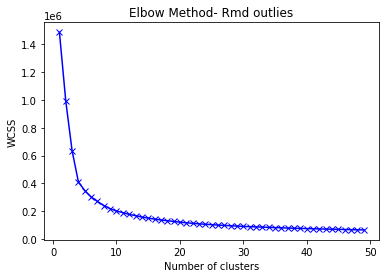

In [44]:
kmeans_fig_rmd_outliers = KMeans_elbow(pca_fit_rmd_outliers,"Elbow Method- Rmd outlies")

For n_clusters = 4 The average silhouette_score is : 0.4017919792232735
For n_clusters = 5 The average silhouette_score is : 0.33607773914635286
For n_clusters = 9 The average silhouette_score is : 0.29417585985747235
For n_clusters = 10 The average silhouette_score is : 0.2944013472907903
For n_clusters = 15 The average silhouette_score is : 0.2808536991652514
For n_clusters = 20 The average silhouette_score is : 0.2721666648358183


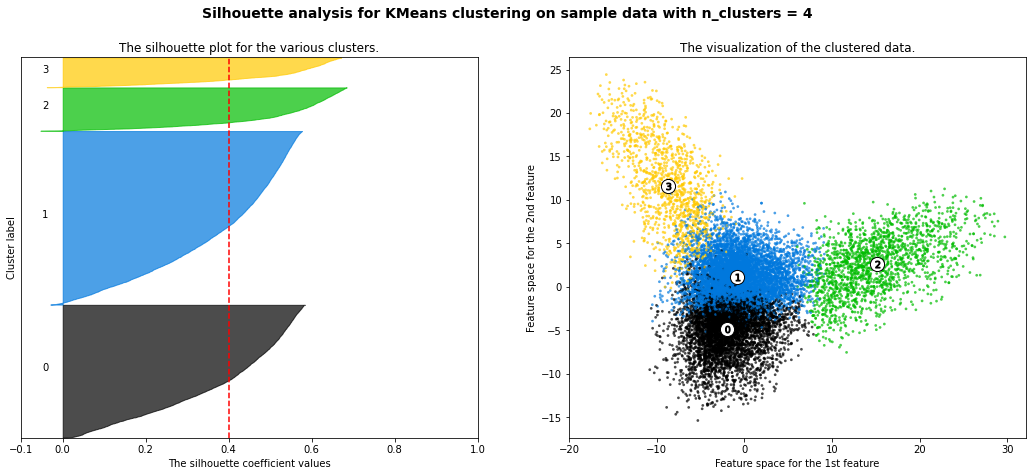

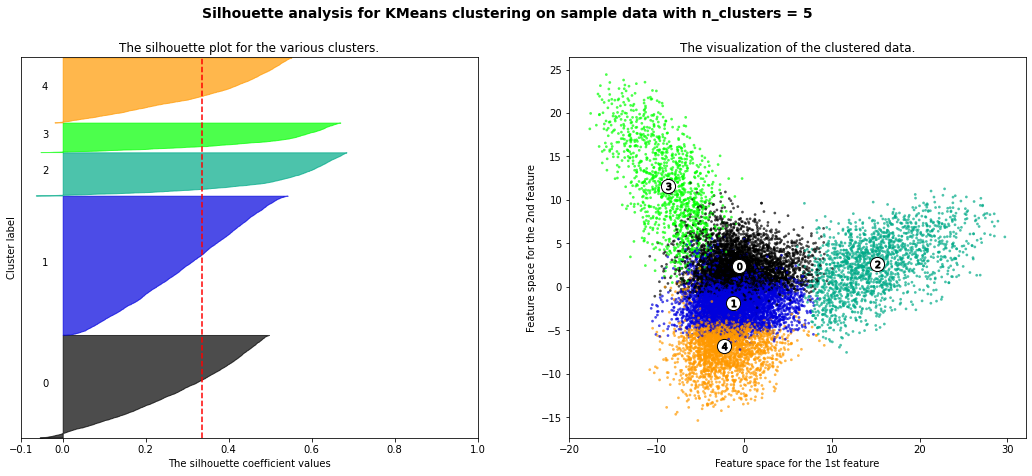

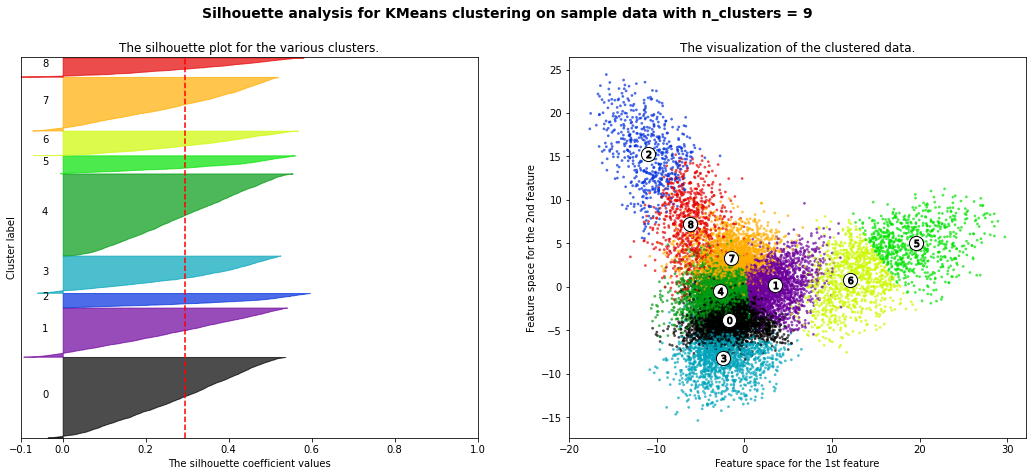

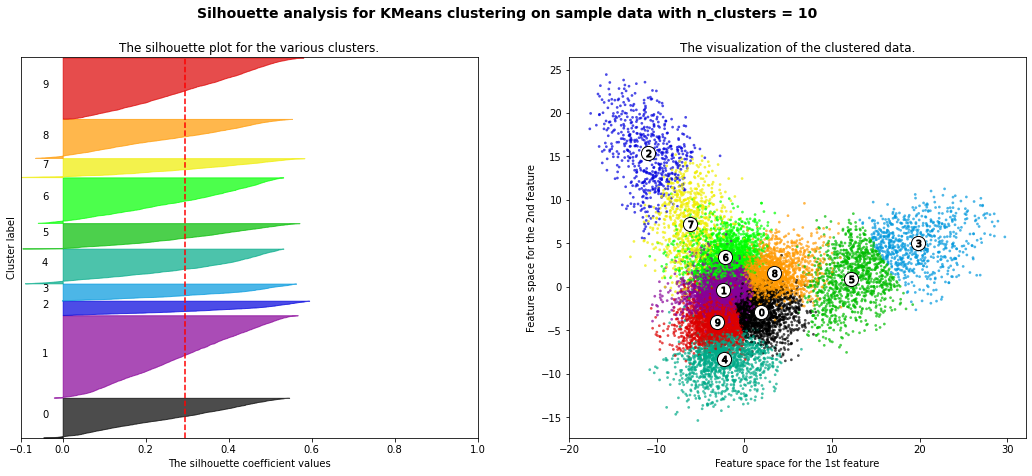

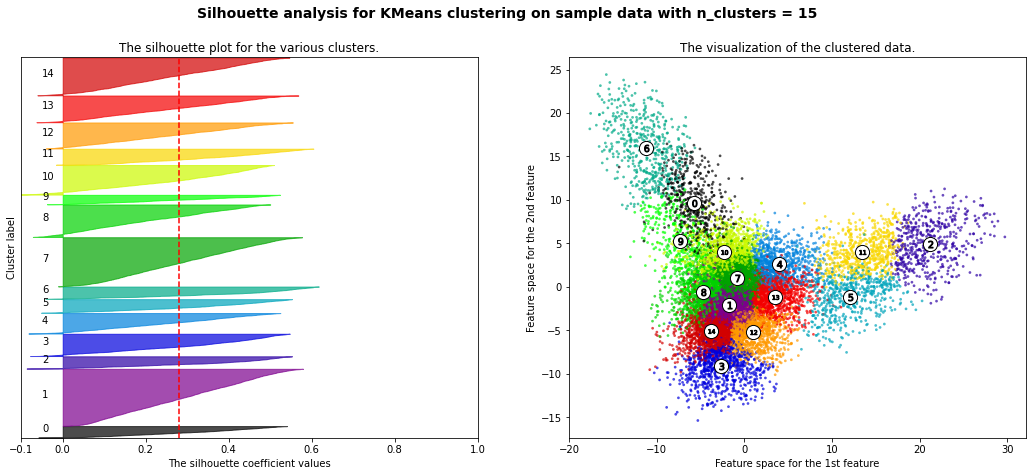

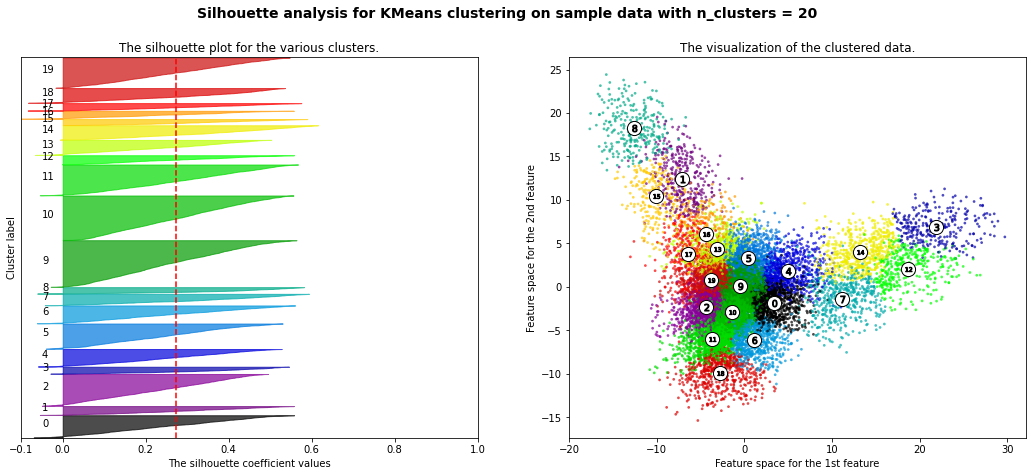

In [46]:
range_n_clusters = [4,5,9,10,15,20]
fig_sillhoette_score_remd_outliers = get_sillhette_score(range_n_clusters,pca_fit_rmd_outliers)

In [ ]:
# As per the above plots and silhouette score (<0.5), the best score is obtained for n_clusters =4
# But, this is not suit for the dataset, there are nine keywords in the dataset  

**GMM model**

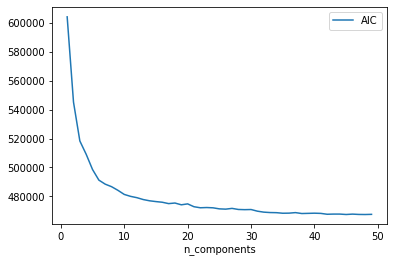

In [35]:
####################### GMM model

n_components = np.arange(1, 50)
models = [GMM(n, covariance_type='full', random_state=0).fit(pca_fit)
          for n in n_components]

# plt.plot(n_components, [m.bic(pca_fit) for m in models], label='BIC')
plt.plot(n_components, [m.aic(pca_fit) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.show()
# there for any convergent point in the graph
# Even n_components extended to 100, same pattern observed
# So, GMM is not suitable for this dataset